In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

df = pd.read_csv('vehicles.csv') # https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data/data

# DATA CLEANING

# remove missing values
df_clean = df.dropna(subset=['price', 'year', 'odometer', 'paint_color']) # type of pollution: missing values
df_clean = df_clean[df_clean['odometer'] > 0] # type of pollution: impossible values

# type of pollution: outliers 
# genuine cars were found at the $150-300 range, and also found that the upper limit did not change results much
df_clean = df_clean[(df_clean['price'] > 100) & (df_clean['price'] < 1000000)]
df_clean = df_clean[df_clean['year'] >= 1950]

df_clean.reset_index(drop=True, inplace=True)
# print(df_clean.describe())
# print(df_clean.info())

ANOVA p-value: 0.0
difference in car prices between different colors.
Probability of being expensive for white: 0.4908150826012022
Probability of being expensive for blue: 0.33042846768336964
Probability of being expensive for red: 0.40237229498358457
Probability of being expensive for black: 0.4658626150820585
Probability of being expensive for silver: 0.3227533363779368
Probability of being expensive for grey: 0.2509879647925274
Probability of being expensive for brown: 0.32525781633655265
Probability of being expensive for yellow: 0.37008281573498963
Probability of being expensive for orange: 0.35130628126737073
Probability of being expensive for green: 0.2084428863569968
Probability of being expensive for custom: 0.2790547102622208
Probability of being expensive for purple: 0.2453416149068323
Average price for condition good: 20997.886751985432
Average price for condition excellent: 15515.260681520314
Average price for condition like new: 19695.91626900808
Average price for conditi

In [19]:
# hypothesis 1 - car color corrlates with price
# group by color and avg car price
color_price = df_clean.groupby('paint_color')['price'].mean().reset_index()

# sort prices to be descending
color_price = color_price.sort_values(by='price', ascending=False)

# used for internal testing, GPT generated
# plt.figure(figsize=(14, 7))
# sns.barplot(x='price', y='paint_color', data=color_price)
# plt.title('Average Car Price by Color')
# plt.xlabel('Average Price ($)')
# plt.ylabel('Paint Color')
# plt.show()

from itertools import combinations # I asked GPT to help me compare each combination of colors for the p tests
import numpy as np 

# permutation test to look for significant differences between two colors
def permutation_test(data1, data2, num_permutations=10000):
    observed_diff = np.mean(data1) - np.mean(data2)
    combined = np.concatenate([data1, data2])
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        if np.abs(np.mean(new_data1) - np.mean(new_data2)) >= np.abs(observed_diff):
            count += 1
    return count / num_permutations

colors = df_clean['paint_color'].unique()

# takes a while, but checks every combination's p-values against each other using the permutation test function above
for color1, color2 in combinations(colors, 2):
    color1_prices = df_clean[df_clean['paint_color'] == color1]['price']
    color2_prices = df_clean[df_clean['paint_color'] == color2]['price']
    p_value = permutation_test(color1_prices, color2_prices)
    
    print(f'Permutation test p-value for {color1} vs {color2}: {p_value}')
    
    if p_value < 0.05:
        print(f'Significant difference in prices between {color1} and {color2}.')
    else:
        print(f'No significant difference in prices between {color1} and {color2}.')


# ANOVA testing to confirm my suspicions
# looking for large enough differences in prices across each color

# give each color an index
df_clean['paint_color_code'] = pd.Categorical(df_clean['paint_color']).codes

# collects prices of cars in each color group and passes them to f_oneway function to perform the comparison
# AKA tests the null hypothesis that two or more color groups have the same average price, for every unique pair
anova_results = stats.f_oneway(*(df_clean[df_clean['paint_color_code'] == code]['price']
                                 for code in df_clean['paint_color_code'].unique()))
print(f'ANOVA p-value: {anova_results.pvalue}')

if anova_results.pvalue < 0.05:
    print("difference in car prices between different colors.")
else:
    print("no difference in car prices between different colors.")

# hypothesis 2 - mileage affects car price
# using linear regression model
# milage = X, price = y
X = df_clean[['odometer']]
y = df_clean['price']
model = LinearRegression().fit(X, y)

# calculating residuals 
# (difference between predicted and actual price)
predicted_prices = model.predict(X)
residuals = y - predicted_prices

# bayesian analysis probability 1 - car being expensive by color
threshold = 20000  # tried 10k, 20k, 25k, 30k, this fit the model the best? most evenly? 
colors = df_clean['paint_color'].unique()

# find probability of being expensive for each color
for color in colors:
    color_data = df_clean[df_clean['paint_color'] == color] # used GPT to generate a tidy display of values
    prob_expensive = (color_data['price'] > threshold).mean()
    print(f'Probability of being expensive for {color}: {prob_expensive}')

# bayesian analysis probability 2 - effect of car condition
if 'condition' in df_clean.columns and df_clean['condition'].dropna().nunique() > 0: # if condition exists
    conditions = df_clean['condition'].dropna().unique()
    for condition in conditions: # used GPT to generate a tidy display of values
        condition_data = df_clean[df_clean['condition'] == condition]
        avg_price = condition_data['price'].mean()
        print(f'Average price for condition {condition}: {avg_price}')

# used for internal testing, GPT generated
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='odometer', y='price', data=df_clean, alpha=0.5)
# plt.title('Car Mileage vs. Price')
# plt.xlabel('Odometer (miles)')
# plt.ylabel('Price ($)')
# plt.show()

Permutation test p-value for white vs blue: 0.0
Significant difference in prices between white and blue.


KeyboardInterrupt: 

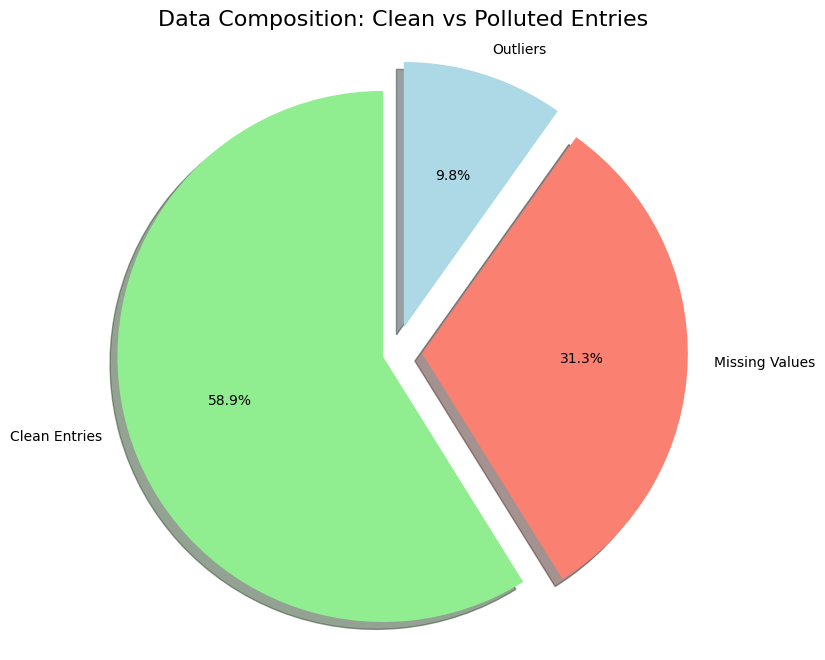

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# PIE CHART
total_entries = len(df)
missing_values = len(df) - len(df.dropna(subset=['price', 'year', 'odometer', 'paint_color']))
outliers = len(df) - len(df[(df['price'] > 100) & (df['price'] < 1000000) & (df['odometer'] > 0) & (df['year'] >= 1950)]) # same conditions as the data cleanup above
clean_entries = total_entries - (missing_values + outliers)

labels = ['Clean Entries', 'Missing Values', 'Outliers']
sizes = [clean_entries, missing_values, outliers]
colors = ['lightgreen', 'salmon', 'lightblue']

fig, ax = plt.subplots(figsize=(8, 8)) # Used GPT to make it look pretty
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.1, 0.1), shadow=True)
ax.axis('equal')  
plt.title('Data Composition: Clean vs Polluted Entries', fontsize=16)
plt.show()

In [20]:
# bayesian Ppobability of being expensive by car color

# color_probabilities = df_clean.groupby('paint_color')['price'].apply(lambda x: (x > threshold).mean()).reset_index()
# plt.figure(figsize=(14, 7))
# sns.barplot(x='paint_color', y='price', data=color_probabilities)
# plt.title('Probability of Being Expensive by Color')
# plt.xlabel('Paint Color')
# plt.ylabel('Probability')
# plt.show()

/var/folders/4d/nh7jtz092cj7c4b2yl0z2gqw0000gn/T/ipykernel_27535/1146661101.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='paint_color', y='price', data=color_price, palette=colors, edgecolor='black') # GPT helped me again making it look pretty


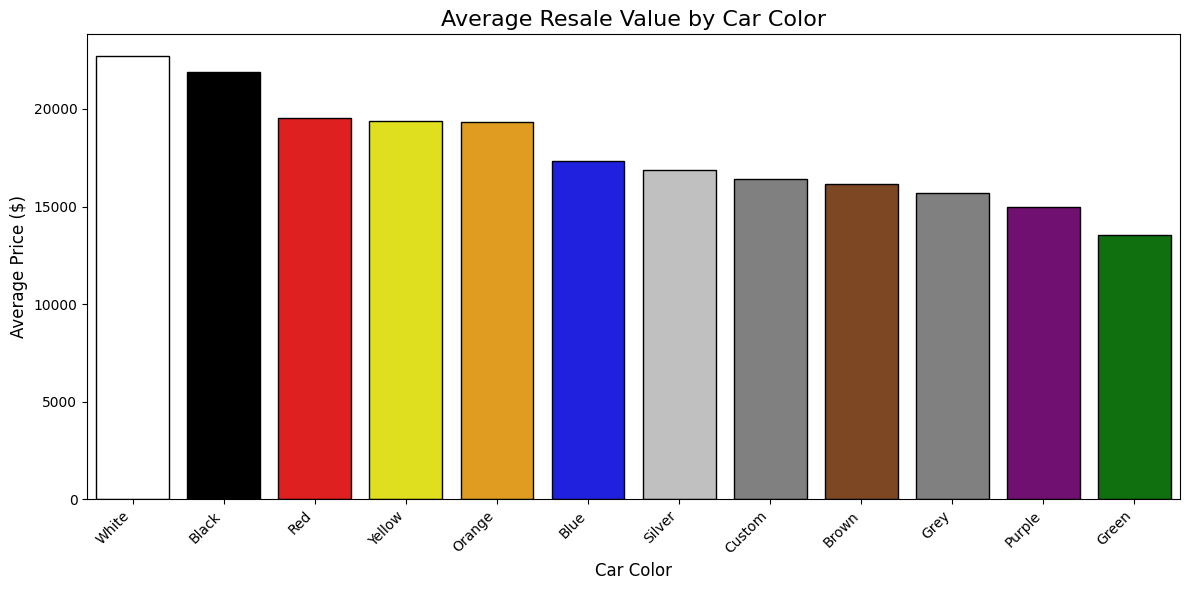

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# group by color to find average price per color
color_price = df_clean.groupby('paint_color')['price'].mean().reset_index()

# fix character casing
color_price['paint_color'] = color_price['paint_color'].str.title()

# sort descending 
color_price = color_price.sort_values(by='price', ascending=False)

color_palette = {
    'White': '#FFFFFF', 'Black': '#000000', 'Silver': '#C0C0C0', 'Red': '#FF0000', 
    'Blue': '#0000FF', 'Gray': '#808080', 'Yellow': '#FFFF00', 'Green': '#008000', 
    'Orange': '#FFA500', 'Brown': '#8B4513', 'Purple': '#800080'
}

colors = [color_palette.get(color, '#808080') for color in color_price['paint_color']] #default color

plt.figure(figsize=(12, 6))
sns.barplot(x='paint_color', y='price', data=color_price, palette=colors, edgecolor='black') # GPT helped me again making it look pretty
plt.title('Average Resale Value by Car Color', fontsize=16)
plt.xlabel('Car Color', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Price Stability by Car Color:
   paint_color          mean           std  price_stability  stability_lower  \
0        black  21921.209140  15403.558834         0.702678         0.632411   
10       white  22691.663178  16160.993964         0.712200         0.640980   
6       orange  19353.868260  14221.611150         0.734820         0.661338   
9       silver  16870.740194  12946.398831         0.767388         0.690649   
8          red  19532.094045  15042.483782         0.770142         0.693128   
2        brown  16145.609592  12914.255454         0.799862         0.719876   
3       custom  16425.321625  13394.373451         0.815471         0.733924   
1         blue  17318.098800  14653.114112         0.846116         0.761504   
5         grey  15670.445168  13754.619515         0.877743         0.789968   
11      yellow  19375.719979  18277.702547         0.943330         0.848997   
4        green  13534.507742  15131.047804         1.117961         1.006165   
7       pu

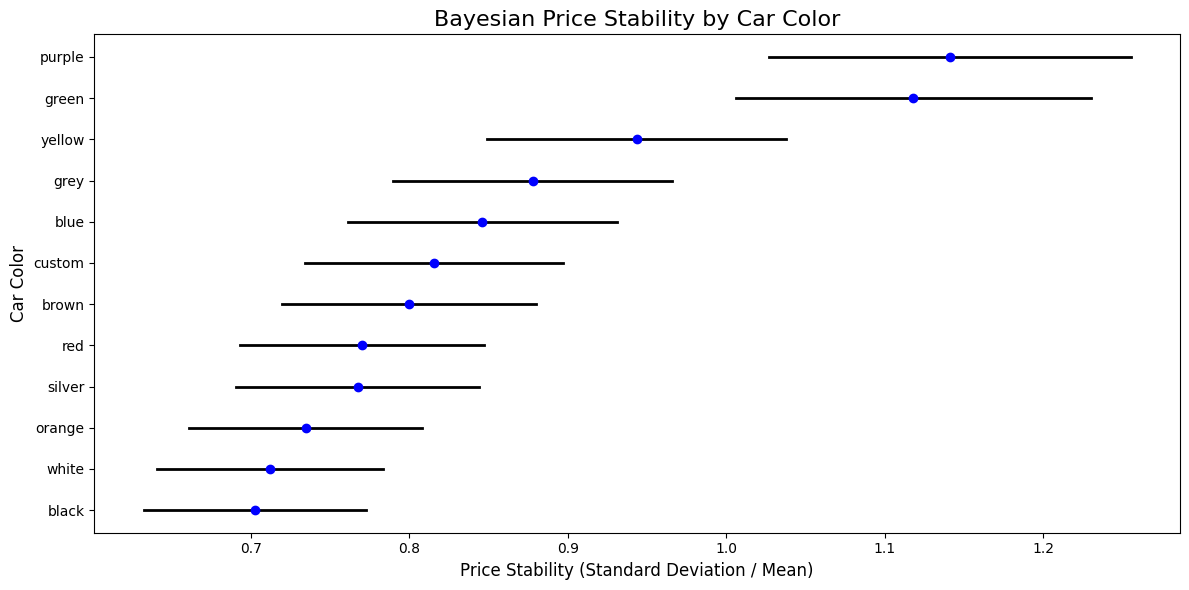

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# group by color to find avg and stdev of price per each color
price_stats = df_clean.groupby('paint_color')['price'].agg(['mean', 'std']).reset_index()

# price stability = stdev / mean
price_stats['price_stability'] = price_stats['std'] / price_stats['mean'] # lower = better

# price stability defined as 0.1 within the calculated stability
price_stats['stability_lower'] = price_stats['price_stability'] - (0.1 * price_stats['price_stability'])
price_stats['stability_upper'] = price_stats['price_stability'] + (0.1 * price_stats['price_stability'])
price_stats = price_stats.sort_values(by='price_stability')

print("Price Stability by Car Color:")
print(price_stats[['paint_color', 'mean', 'std', 'price_stability', 'stability_lower', 'stability_upper']])

plt.figure(figsize=(12, 6))

for i in range(len(price_stats)):
    plt.plot([price_stats['stability_lower'].iloc[i], price_stats['stability_upper'].iloc[i]], [i, i], color='black', lw=2)
    # plot stability points scatter
    plt.scatter(price_stats['price_stability'].iloc[i], i, color='blue', zorder=3)

plt.yticks(np.arange(len(price_stats)), price_stats['paint_color']) # GPT helped me again making it look pretty
plt.title('Bayesian Price Stability by Car Color', fontsize=16)
plt.xlabel('Price Stability (Standard Deviation / Mean)', fontsize=12)
plt.ylabel('Car Color', fontsize=12)
plt.tight_layout()
plt.show()